In [11]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.feature import hessian_matrix, hessian_matrix_eigvals

In [12]:
def print_img(vol, axis, slice_=None, title= 'title', cmap='hot'):
    axis.set_title(title)
    im = axis.imshow(vol[:, :, slice_], cmap=cmap)
    plt.colorbar(im)

    
def hessian_detect_2016(img, sigma, tau=0.5):
    assert len(img.shape)==3
    H = hessian_matrix(img, sigma, use_gaussian_derivatives=False)
    eigvals = hessian_matrix_eigvals(H)
    sorted_eigvals = eigvals[np.argsort(np.abs(eigvals[:, 0, 0, 0]), 0)]
        
    #bright structures on dark background 
    l_1 = -sorted_eigvals[0]
    l_2 = -sorted_eigvals[1]
    l_3 = -sorted_eigvals[2]
    
    M = tau*np.max(l_3) 

    l_rho = np.where((l_3 > 0)*(l_3 <= M), M, l_3)
    l_rho = np.where(l_rho < 0, 0, l_rho)
    
    out = np.zeros_like(l_rho)

    out = np.where((l_2 > 0)*(l_rho > 0), (l_2**2) * (l_rho - l_2) * (27.0/((l_2+l_rho)**3)), 0)
    out = np.where((l_2 > 0)*(l_rho > 0)*(l_2 > l_rho/2), 1, out)
    
    return(out) 


def save_vol_as_nii(numpy_arr, affine, path_to_save):
    empty_header = nib.Nifti1Header()
    Nifti1Image = nib.Nifti1Image(numpy_arr, affine, empty_header)
    nib.save(Nifti1Image, path_to_save)

In [13]:
sample_name= "IXI020"

path_to_nii_file = f"/home/msst/{sample_name}.nii.gz"

vol_file = nib.load(path_to_nii_file)
brain_vol = np.array(vol_file.dataobj)

print(brain_vol.shape)

(512, 512, 100)


In [14]:
hd2016_outs = []
sigmas = [0.9, 1.6, 2.3, 3.0]
for s in tqdm(sigmas):
    hd2016_outs.append(hessian_detect_2016(brain_vol, sigma=s, tau=0.5))
    
hd2016_out = np.max(np.array(hd2016_outs), axis=0)

  0%|                                                     | 0/4 [00:00<?, ?it/s]/tmp/ipykernel_2397/1491825207.py:25: RuntimeWarning: divide by zero encountered in divide
  out = np.where((l_2 > 0)*(l_rho > 0), (l_2**2) * (l_rho - l_2) * (27.0/((l_2+l_rho)**3)), 0)
/tmp/ipykernel_2397/1491825207.py:25: RuntimeWarning: overflow encountered in divide
  out = np.where((l_2 > 0)*(l_rho > 0), (l_2**2) * (l_rho - l_2) * (27.0/((l_2+l_rho)**3)), 0)
/tmp/ipykernel_2397/1491825207.py:25: RuntimeWarning: invalid value encountered in multiply
  out = np.where((l_2 > 0)*(l_rho > 0), (l_2**2) * (l_rho - l_2) * (27.0/((l_2+l_rho)**3)), 0)
100%|█████████████████████████████████████████████| 4/4 [00:56<00:00, 14.11s/it]


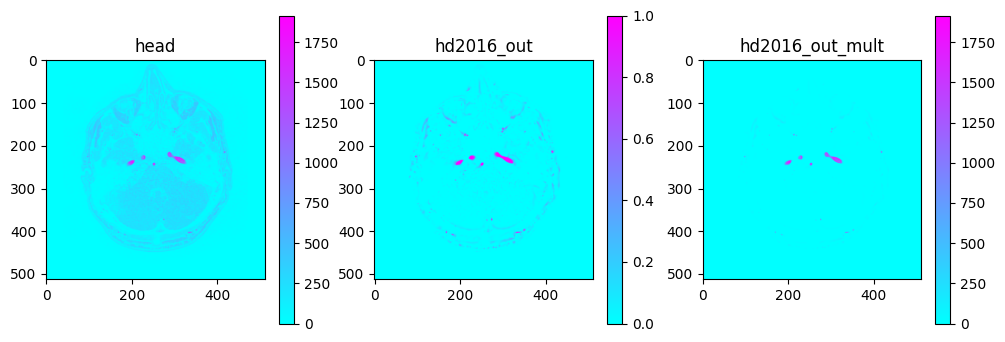

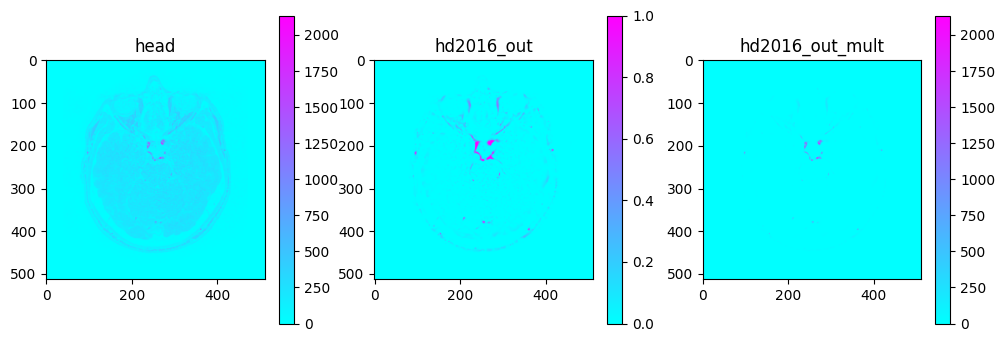

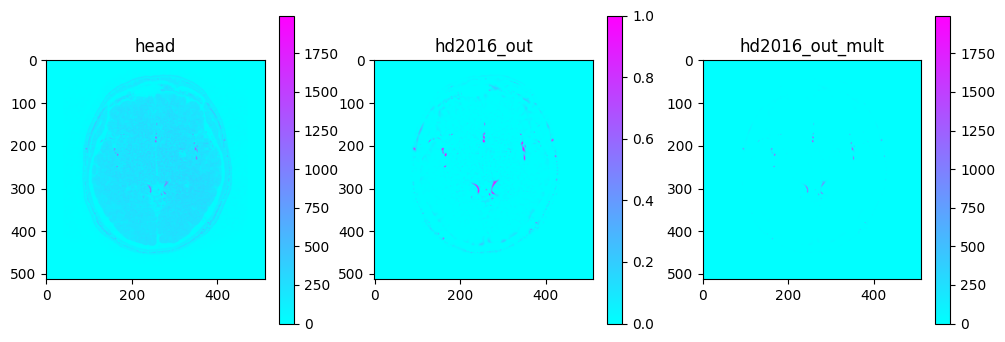

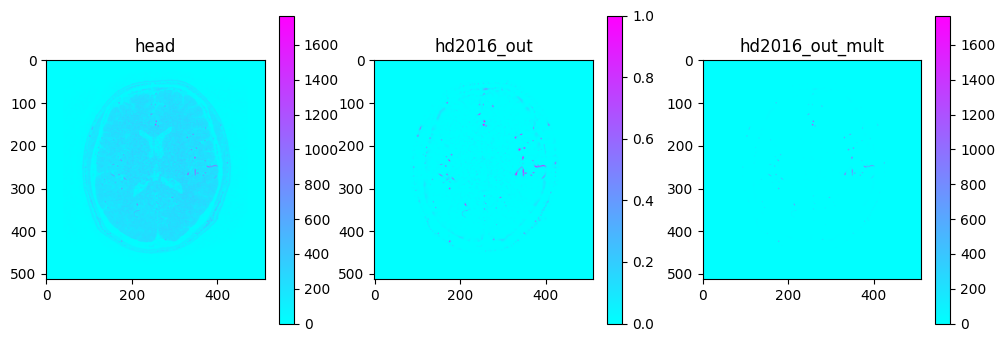

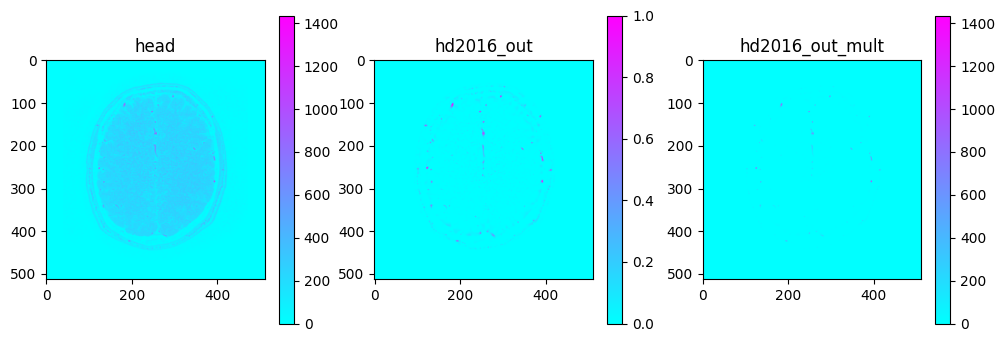

In [17]:
cmap = 'cool'
for idx in range(10, 100, 20):    
    SHOW_SLICE = idx

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))    
    print_img(brain_vol, ax[0], slice_=idx, title='head', cmap=cmap)  
    print_img(hd2016_out, ax[1], slice_=idx, title='hd2016_out', cmap=cmap)    
    print_img(hd2016_out*brain_vol, ax[2], slice_=idx, title='hd2016_out_mult', cmap=cmap)   

In [ ]:
path_to_save = f"/home/msst/{sample_name}_hd2016.nii.gz"
save_vol_as_nii(hd2016_out, vol_file.affine, path_to_save)

path_to_save = f"/home/msst/{sample_name}_hd2016_mult.nii.gz"
save_vol_as_nii(brain_vol*hd2016_out, vol_file.affine, path_to_save)